In [44]:
%matplotlib inline

import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import preprocessing

import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.ensemble import VotingClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [45]:
fundamentals = pd.read_csv('fundamentals.csv',index_col = 0)
price_split=pd.read_csv('prices-split-adjusted.csv')
securities = pd.read_csv('securities.csv')
sectors = securities['GICS Sector'].unique()
sub_industry = securities['GICS Sub Industry'].unique()
accounts = fundamentals.columns.values[2:]

In [46]:
fundamentals = fundamentals.rename(columns={'Period Ending': 'date'})

In [47]:
fundamentals = fundamentals.rename(columns={'Ticker Symbol': 'symbol'})

In [48]:
new_data=pd.merge(fundamentals, price_split, on='date', how='left')

In [49]:
new_data1=new_data[new_data["symbol_x"]==new_data["symbol_y"]]

In [50]:
new_data1.drop(['symbol_y'], axis=1,inplace=True)

In [51]:
new_data1=new_data1.rename(columns={'symbol_x':'symbol'})

In [52]:
securities=securities.rename(columns={'Ticker symbol':'symbol'})

In [53]:
new_data2=pd.merge(new_data1, securities, on='symbol', how='left')

In [54]:
#create the For year column again to get rid of null values
new_data2['For Year']=new_data2.date.str.split("-",expand=True,)[0]

In [55]:
#drop Equity Earnings/Loss Unconsolidated Subsidiary because 60% of the data is zero??
#new_data2[new_data2['Equity Earnings/Loss Unconsolidated Subsidiary']==0]
new_data2.drop(['CIK','SEC filings','Date first added','Equity Earnings/Loss Unconsolidated Subsidiary'], axis=1,inplace=True)

In [56]:
new_data2['PE'] = new_data2['close'] / new_data2['Earnings Per Share']

In [57]:
import warnings
warnings.filterwarnings("ignore")

new_data2['date']=pd.to_datetime(new_data2['date'])

In [58]:
#missing EPS valuses as zero because its possible the company wasnt public
new_data2[['Earnings Per Share']] = new_data2[['Earnings Per Share']].fillna(value=0)
new_data2[['PE']] = new_data2[['PE']].fillna(value=0)

In [59]:
#negative P/E ratio indicates bankrupcy
new_data2['trend']=np.where(new_data2['PE']>0, '1', '0')

In [60]:
new_data2.isnull().sum()

symbol                                                   0
date                                                     0
Accounts Payable                                         0
Accounts Receivable                                      0
Add'l income/expense items                               0
After Tax ROE                                            0
Capital Expenditures                                     0
Capital Surplus                                          0
Cash Ratio                                             272
Cash and Cash Equivalents                                0
Changes in Inventories                                   0
Common Stocks                                            0
Cost of Revenue                                          0
Current Ratio                                          272
Deferred Asset Charges                                   0
Deferred Liability Charges                               0
Depreciation                                            

In [61]:
new_data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1357 entries, 0 to 1356
Data columns (total 88 columns):
symbol                                                 1357 non-null object
date                                                   1357 non-null datetime64[ns]
Accounts Payable                                       1357 non-null float64
Accounts Receivable                                    1357 non-null float64
Add'l income/expense items                             1357 non-null float64
After Tax ROE                                          1357 non-null float64
Capital Expenditures                                   1357 non-null float64
Capital Surplus                                        1357 non-null float64
Cash Ratio                                             1085 non-null float64
Cash and Cash Equivalents                              1357 non-null float64
Changes in Inventories                                 1357 non-null float64
Common Stocks                           

In [62]:
#fill the missing values with 0 for now - need to figure this out
new_data2.fillna(value='0',inplace=True)

In [63]:
for col in ['Cash Ratio','Current Ratio','Quick Ratio','Estimated Shares Outstanding','trend']:
    new_data2[col] = new_data2[col].astype('float64')

In [64]:
for col in ['For Year','Security','GICS Sector','GICS Sub Industry']:
    new_data2[col] = new_data2[col].astype('category')

In [65]:
new_data2.drop(['Address of Headquarters'], axis=1,inplace=True)

In [66]:
new_data2.head()

,symbol,date,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,...,open,close,low,high,volume,Security,GICS Sector,GICS Sub Industry,PE,trend
0,AAL,2012-12-31,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,1.330000e+09,...,12.850000,13.500000,12.840000,13.680000,7005600.0,American Airlines Group,Industrials,Airlines,-2.410714,0.0
1,AAL,2013-12-31,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,2.175000e+09,...,24.740000,25.250000,24.629999,25.250000,7166600.0,American Airlines Group,Industrials,Airlines,-2.244444,0.0
2,AAL,2014-12-31,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,1.768000e+09,...,53.900002,53.630001,53.320000,54.639999,10626000.0,American Airlines Group,Industrials,Airlines,13.340796,1.0
3,AAL,2015-12-31,5.102000e+09,352000000.0,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,1.085000e+09,...,42.540001,42.349998,41.830002,42.570000,6788900.0,American Airlines Group,Industrials,Airlines,3.718174,1.0
4,ABBV,2013-12-31,6.448000e+09,681000000.0,-5.400000e+07,92.0,-4.910000e+08,3.671000e+09,144.0,9.595000e+09,...,52.990002,52.810001,52.360001,53.060001,3019700.0,AbbVie,Health Care,Pharmaceuticals,20.468993,1.0


In [67]:
new_data2.drop(['symbol'], axis=1,inplace=True)

In [68]:
new_data2.drop(['date'], axis=1,inplace=True)

In [69]:
for col in ['For Year','Security','GICS Sector','GICS Sub Industry']:
    new_data2[col] = new_data2[col].cat.codes

In [70]:
new_data2.shape

(1357, 85)

In [71]:
#names = new_data2.columns[0:84]
# Create the Scaler object
#scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
#scaled_df = scaler.fit_transform(new_data2[names])
#scaled_df = pd.DataFrame(scaled_df, columns=names)
#new_data3=pd.concat([scaled_df, new_data2['trend']], axis=1)

In [72]:
#new_data3=new_data2[[ 'After Tax ROE','Current Ratio','Earnings Before Interest and Tax','Earnings Before Tax','Gross Profit','Net Cash Flow','Net Income','Profit Margin','Quick Ratio','Total Assets','Total Equity','Total Liabilities','Total Liabilities & Equity','Total Revenue','For Year', 'Earnings Per Share','open', 'close', 'low', 'high', 'volume', 'Security', 'GICS Sector',
#        'PE','trend']]

In [73]:
new_data2.shape

(1357, 85)

In [74]:
#save
new_data2.to_csv('merged_data.csv')

In [75]:
new_data2.to_csv('/Users/zhongyizhang/Desktop/merged_data.csv')

### PCA

In [76]:
new_data2.head()

,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,Changes in Inventories,Common Stocks,...,open,close,low,high,volume,Security,GICS Sector,GICS Sub Industry,PE,trend
0,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,1.330000e+09,0.0,127000000.0,...,12.850000,13.500000,12.840000,13.680000,7005600.0,22,5,4,-2.410714,0.0
1,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,2.175000e+09,0.0,5000000.0,...,24.740000,25.250000,24.629999,25.250000,7166600.0,22,5,4,-2.244444,0.0
2,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,1.768000e+09,0.0,7000000.0,...,53.900002,53.630001,53.320000,54.639999,10626000.0,22,5,4,13.340796,1.0
3,5.102000e+09,352000000.0,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,1.085000e+09,0.0,6000000.0,...,42.540001,42.349998,41.830002,42.570000,6788900.0,22,5,4,3.718174,1.0
4,6.448000e+09,681000000.0,-5.400000e+07,92.0,-4.910000e+08,3.671000e+09,144.0,9.595000e+09,-56000000.0,16000000.0,...,52.990002,52.810001,52.360001,53.060001,3019700.0,4,4,87,20.468993,1.0


In [77]:
pca_data = new_data2.drop(['open', 'low', 'high'], axis=1)

In [78]:
def fit_pca(df, n_components):
    pca = PCA(n_components)
    pca.fit(df)   
    return pca

In [79]:
pca_naive = fit_pca(pca_data, n_components=20)

In [80]:
def plot_naive_variance(pca):
    fig, ax = plt.subplots(figsize=(10,6))

    ax.set_xlabel('Dimension #')
    ax.set_ylabel('Explained Variance Ratio')
    ax.set_title('Fraction of Explained Variance')
    ax.plot(pca.explained_variance_ratio_)

    return ax

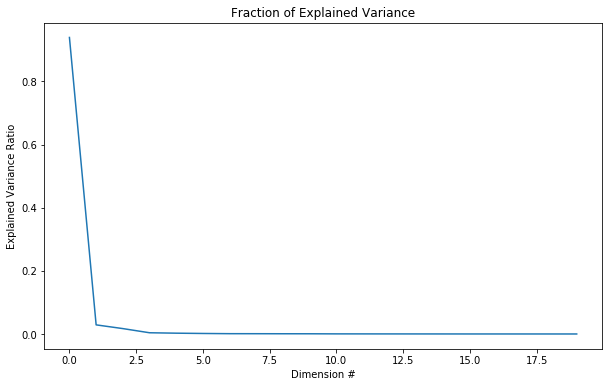

In [81]:
naive_var = plot_naive_variance(pca_naive)

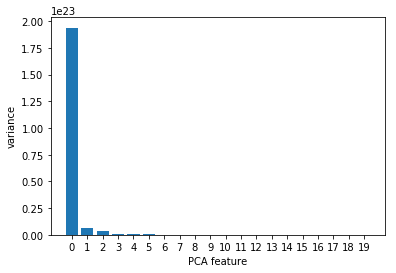

In [82]:
features = range(pca_naive.n_components_)
plt.bar(features, pca_naive.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

### Standardized data

In [83]:
def standardize(df):
    stscaler = StandardScaler().fit(df)
    scaled = stscaler.transform(df)    
    return scaled

In [84]:
scaled = standardize(pca_data)

In [85]:
pca = fit_pca(scaled, n_components=20)

In [86]:
ax = plot_scaled_variance(pca)

NameError: name 'plot_scaled_variance' is not defined

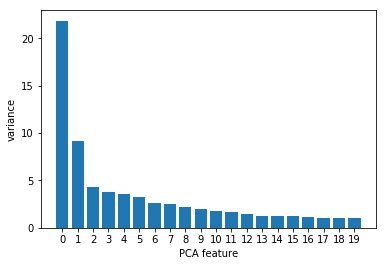

In [87]:
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

In [88]:
n_components

NameError: name 'n_components' is not defined

In [89]:
vars = pca.explained_variance_ratio_
c_names = ['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10',
           'f11','f12','f13','f14','f15','f16','f17','f18','f19','f20',
           'f21','f22','f23','f24','f25','f26','f27','f28','f29','f30',
           'f31','f32','f33','f34','f35','f36','f37','f38','f39','f40',
           'f41','f42','f43','f44','f45','f46','f47','f48','f49','f50',
           'f51','f52','f53','f54','f55','f56','f57','f58','f59','f60',
           'f61','f62','f63','f64','f65','f66','f67','f68','f69','f70',
           'f71','f72','f73','f74','f75','f76','f77','f78','f79','f80',
           'f81','f82']

print('Variance:  Projected dimension')
print('------------------------------')
for idx, row in enumerate(pca.components_):
    output = '{0:4.1f}%:    '.format(100.0 * vars[idx])
    output += " + ".join("{0:5.2f} * {1:s}".format(val, name) for val, name in zip(row, c_names))
    print(output)

Variance:  Projected dimension
------------------------------
26.6%:     0.18 * f1 +  0.02 * f2 +  0.06 * f3 + -0.01 * f4 + -0.12 * f5 +  0.13 * f6 + -0.02 * f7 +  0.15 * f8 + -0.03 * f9 +  0.10 * f10 +  0.11 * f11 + -0.03 * f12 +  0.04 * f13 +  0.11 * f14 +  0.14 * f15 +  0.20 * f16 +  0.18 * f17 + -0.09 * f18 +  0.12 * f19 +  0.14 * f20 + -0.01 * f21 +  0.17 * f22 +  0.17 * f23 +  0.08 * f24 +  0.14 * f25 +  0.07 * f26 + -0.09 * f27 +  0.00 * f28 +  0.15 * f29 +  0.15 * f30 +  0.10 * f31 +  0.01 * f32 + -0.03 * f33 + -0.01 * f34 +  0.18 * f35 +  0.00 * f36 + -0.12 * f37 +  0.18 * f38 + -0.02 * f39 +  0.18 * f40 +  0.18 * f41 +  0.15 * f42 +  0.05 * f43 +  0.16 * f44 + -0.02 * f45 +  0.09 * f46 +  0.08 * f47 +  0.14 * f48 + -0.07 * f49 +  0.09 * f50 + -0.01 * f51 +  0.04 * f52 +  0.05 * f53 +  0.11 * f54 + -0.01 * f55 + -0.01 * f56 + -0.01 * f57 + -0.03 * f58 +  0.05 * f59 +  0.17 * f60 + -0.09 * f61 +  0.19 * f62 +  0.15 * f63 +  0.05 * f64 +  0.17 * f65 +  0.10 * f66 +  0.12 * f67 +

In [90]:
# 82.7% are explained by PCA 20 features
26.6 + 11.2 + 5.3 + 4.6 + 4.4 + 4.0 + 3.1 + 3.0 + 2.4 + 2.4 + 2.2 + 2.0 + 1.7 + 1.6 + 1.5 + 1.5 +1.4 +1.3 + 1.3 + 1.2

82.7

In [91]:
reduced = pca.transform(scaled)

In [92]:
scaled.shape

(1357, 82)

In [93]:
reduced.shape

(1357, 20)

In [94]:
# Troy, please use "reduced" to run clustering. 
# Feel free to edit the PCA part, we can drop more columns when create "pca_data".

In [95]:
reduced

array([[-1.56278518, -0.73125649,  0.979929  , ..., -1.36109985,
        -1.59843572,  0.335719  ],
       [-0.97675835, -0.51000576,  1.41342172, ..., -0.9464193 ,
        -1.26481012,  0.78010772],
       [ 1.5131968 ,  1.09891011,  0.3491423 , ..., -0.84144827,
        -1.10539432,  0.55619247],
       ...,
       [-1.89060804, -0.18789026, -0.09751717, ...,  0.70278727,
         0.62356353, -0.63384375],
       [-1.87158422, -0.23230802,  0.20606252, ...,  1.01976161,
         0.88916282, -0.40972124],
       [-1.80912161, -0.22620548, -0.08895374, ...,  1.40657423,
         1.31439418, -0.13727519]])

In [96]:
type(reduced)

numpy.ndarray

In [97]:
df11 = pd.DataFrame(data=reduced)

In [98]:
#df11

## t-SNE

In [99]:
data00=new_data2

In [106]:
data00

,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,Changes in Inventories,Common Stocks,...,open,close,low,high,volume,Security,GICS Sector,GICS Sub Industry,PE,trend
0,3.068000e+09,-2.220000e+08,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,1.330000e+09,0.000000e+00,1.270000e+08,...,12.850000,13.500000,12.840000,13.680000,7005600.0,22,5,4,-2.410714,0.0
1,4.975000e+09,-9.300000e+07,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,2.175000e+09,0.000000e+00,5.000000e+06,...,24.740000,25.250000,24.629999,25.250000,7166600.0,22,5,4,-2.244444,0.0
2,4.668000e+09,-1.600000e+08,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,1.768000e+09,0.000000e+00,7.000000e+06,...,53.900002,53.630001,53.320000,54.639999,10626000.0,22,5,4,13.340796,1.0
3,5.102000e+09,3.520000e+08,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,1.085000e+09,0.000000e+00,6.000000e+06,...,42.540001,42.349998,41.830002,42.570000,6788900.0,22,5,4,3.718174,1.0
4,6.448000e+09,6.810000e+08,-5.400000e+07,92.0,-4.910000e+08,3.671000e+09,144.0,9.595000e+09,-5.600000e+07,1.600000e+07,...,52.990002,52.810001,52.360001,53.060001,3019700.0,4,4,87,20.468993,1.0
5,6.954000e+09,-1.720000e+08,-6.510000e+08,102.0,-6.120000e+08,4.194000e+09,74.0,8.348000e+09,-2.030000e+08,1.600000e+07,...,66.720001,65.440002,65.349998,67.099998,3917300.0,4,4,87,58.954957,1.0
6,8.463000e+09,-1.076000e+09,-2.060000e+08,130.0,-5.320000e+08,1.308000e+10,77.0,8.399000e+09,-4.340000e+08,1.700000e+07,...,59.500000,59.240002,59.200001,59.930000,6019300.0,4,4,87,18.806350,1.0
7,1.487064e+10,-2.312518e+09,-4.400000e+04,19.0,-2.024500e+08,2.360992e+09,8.0,1.231006e+09,-1.486572e+09,2.678000e+06,...,60.900002,61.099998,60.689999,61.270000,1040200.0,29,4,44,32.499999,1.0
8,1.725016e+10,-9.382860e+08,-2.859400e+07,14.0,-2.644570e+08,2.749185e+09,10.0,1.808513e+09,-1.304569e+09,2.711000e+06,...,77.650002,77.300003,77.190002,78.019997,1373500.0,29,4,44,63.360658,1.0
9,2.157823e+10,-1.478793e+09,-4.422000e+07,22.0,-2.315850e+08,3.736477e+09,10.0,2.167442e+09,-1.379189e+09,2.750000e+06,...,96.080002,94.989998,94.070000,96.680000,2381200.0,29,4,44,-153.209674,0.0


In [107]:
data2015=data00.loc[data00['For Year'] == '2015']

In [108]:
data2015

,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,Changes in Inventories,Common Stocks,...,open,close,low,high,volume,Security,GICS Sector,GICS Sub Industry,PE,trend


In [109]:
x=data2015.iloc[:,0:84]
y=data2015.trend

In [110]:
x

,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,Changes in Inventories,Common Stocks,...,Estimated Shares Outstanding,open,close,low,high,volume,Security,GICS Sector,GICS Sub Industry,PE


In [111]:
new_data2

,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,Changes in Inventories,Common Stocks,...,open,close,low,high,volume,Security,GICS Sector,GICS Sub Industry,PE,trend
0,3.068000e+09,-2.220000e+08,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,1.330000e+09,0.000000e+00,1.270000e+08,...,12.850000,13.500000,12.840000,13.680000,7005600.0,22,5,4,-2.410714,0.0
1,4.975000e+09,-9.300000e+07,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,2.175000e+09,0.000000e+00,5.000000e+06,...,24.740000,25.250000,24.629999,25.250000,7166600.0,22,5,4,-2.244444,0.0
2,4.668000e+09,-1.600000e+08,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,1.768000e+09,0.000000e+00,7.000000e+06,...,53.900002,53.630001,53.320000,54.639999,10626000.0,22,5,4,13.340796,1.0
3,5.102000e+09,3.520000e+08,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,1.085000e+09,0.000000e+00,6.000000e+06,...,42.540001,42.349998,41.830002,42.570000,6788900.0,22,5,4,3.718174,1.0
4,6.448000e+09,6.810000e+08,-5.400000e+07,92.0,-4.910000e+08,3.671000e+09,144.0,9.595000e+09,-5.600000e+07,1.600000e+07,...,52.990002,52.810001,52.360001,53.060001,3019700.0,4,4,87,20.468993,1.0
5,6.954000e+09,-1.720000e+08,-6.510000e+08,102.0,-6.120000e+08,4.194000e+09,74.0,8.348000e+09,-2.030000e+08,1.600000e+07,...,66.720001,65.440002,65.349998,67.099998,3917300.0,4,4,87,58.954957,1.0
6,8.463000e+09,-1.076000e+09,-2.060000e+08,130.0,-5.320000e+08,1.308000e+10,77.0,8.399000e+09,-4.340000e+08,1.700000e+07,...,59.500000,59.240002,59.200001,59.930000,6019300.0,4,4,87,18.806350,1.0
7,1.487064e+10,-2.312518e+09,-4.400000e+04,19.0,-2.024500e+08,2.360992e+09,8.0,1.231006e+09,-1.486572e+09,2.678000e+06,...,60.900002,61.099998,60.689999,61.270000,1040200.0,29,4,44,32.499999,1.0
8,1.725016e+10,-9.382860e+08,-2.859400e+07,14.0,-2.644570e+08,2.749185e+09,10.0,1.808513e+09,-1.304569e+09,2.711000e+06,...,77.650002,77.300003,77.190002,78.019997,1373500.0,29,4,44,63.360658,1.0
9,2.157823e+10,-1.478793e+09,-4.422000e+07,22.0,-2.315850e+08,3.736477e+09,10.0,2.167442e+09,-1.379189e+09,2.750000e+06,...,96.080002,94.989998,94.070000,96.680000,2381200.0,29,4,44,-153.209674,0.0


In [112]:
newdata = new_data2

In [113]:
newdata

,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,Changes in Inventories,Common Stocks,...,open,close,low,high,volume,Security,GICS Sector,GICS Sub Industry,PE,trend
0,3.068000e+09,-2.220000e+08,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,1.330000e+09,0.000000e+00,1.270000e+08,...,12.850000,13.500000,12.840000,13.680000,7005600.0,22,5,4,-2.410714,0.0
1,4.975000e+09,-9.300000e+07,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,2.175000e+09,0.000000e+00,5.000000e+06,...,24.740000,25.250000,24.629999,25.250000,7166600.0,22,5,4,-2.244444,0.0
2,4.668000e+09,-1.600000e+08,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,1.768000e+09,0.000000e+00,7.000000e+06,...,53.900002,53.630001,53.320000,54.639999,10626000.0,22,5,4,13.340796,1.0
3,5.102000e+09,3.520000e+08,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,1.085000e+09,0.000000e+00,6.000000e+06,...,42.540001,42.349998,41.830002,42.570000,6788900.0,22,5,4,3.718174,1.0
4,6.448000e+09,6.810000e+08,-5.400000e+07,92.0,-4.910000e+08,3.671000e+09,144.0,9.595000e+09,-5.600000e+07,1.600000e+07,...,52.990002,52.810001,52.360001,53.060001,3019700.0,4,4,87,20.468993,1.0
5,6.954000e+09,-1.720000e+08,-6.510000e+08,102.0,-6.120000e+08,4.194000e+09,74.0,8.348000e+09,-2.030000e+08,1.600000e+07,...,66.720001,65.440002,65.349998,67.099998,3917300.0,4,4,87,58.954957,1.0
6,8.463000e+09,-1.076000e+09,-2.060000e+08,130.0,-5.320000e+08,1.308000e+10,77.0,8.399000e+09,-4.340000e+08,1.700000e+07,...,59.500000,59.240002,59.200001,59.930000,6019300.0,4,4,87,18.806350,1.0
7,1.487064e+10,-2.312518e+09,-4.400000e+04,19.0,-2.024500e+08,2.360992e+09,8.0,1.231006e+09,-1.486572e+09,2.678000e+06,...,60.900002,61.099998,60.689999,61.270000,1040200.0,29,4,44,32.499999,1.0
8,1.725016e+10,-9.382860e+08,-2.859400e+07,14.0,-2.644570e+08,2.749185e+09,10.0,1.808513e+09,-1.304569e+09,2.711000e+06,...,77.650002,77.300003,77.190002,78.019997,1373500.0,29,4,44,63.360658,1.0
9,2.157823e+10,-1.478793e+09,-4.422000e+07,22.0,-2.315850e+08,3.736477e+09,10.0,2.167442e+09,-1.379189e+09,2.750000e+06,...,96.080002,94.989998,94.070000,96.680000,2381200.0,29,4,44,-153.209674,0.0


In [114]:
x=newdata.iloc[:,0:84]
y=newdata.trend

In [115]:
trend = newdata['trend'].astype('category').cat.codes

In [116]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
model=TSNE(learning_rate=100)
Tsne_transformed=model.fit_transform(x)

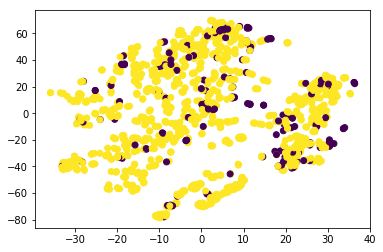

In [117]:
xs =Tsne_transformed[:,0]
ys=Tsne_transformed[:,1]
plt.scatter(xs,ys, c=trend)
plt.show()

In [118]:
#newdata

In [119]:
#newdata.iloc[:,84:85]
#newdata.trend

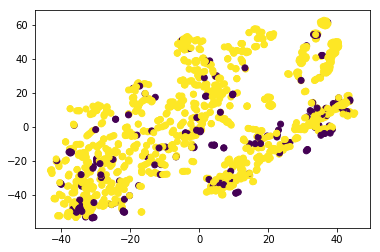

In [120]:

seeds = newdata.iloc[:,0:84].values

labels = newdata.iloc[:,84:85].values

#labels=trend2.values
result = labels[:, 0]

from sklearn.manifold import TSNE

model = TSNE(learning_rate=150)

tsne_features = model.fit_transform(seeds)

xs2 = tsne_features[:,0]

ys2 = tsne_features[:,1]

plt.scatter(xs2, ys2, c=result)
plt.show()

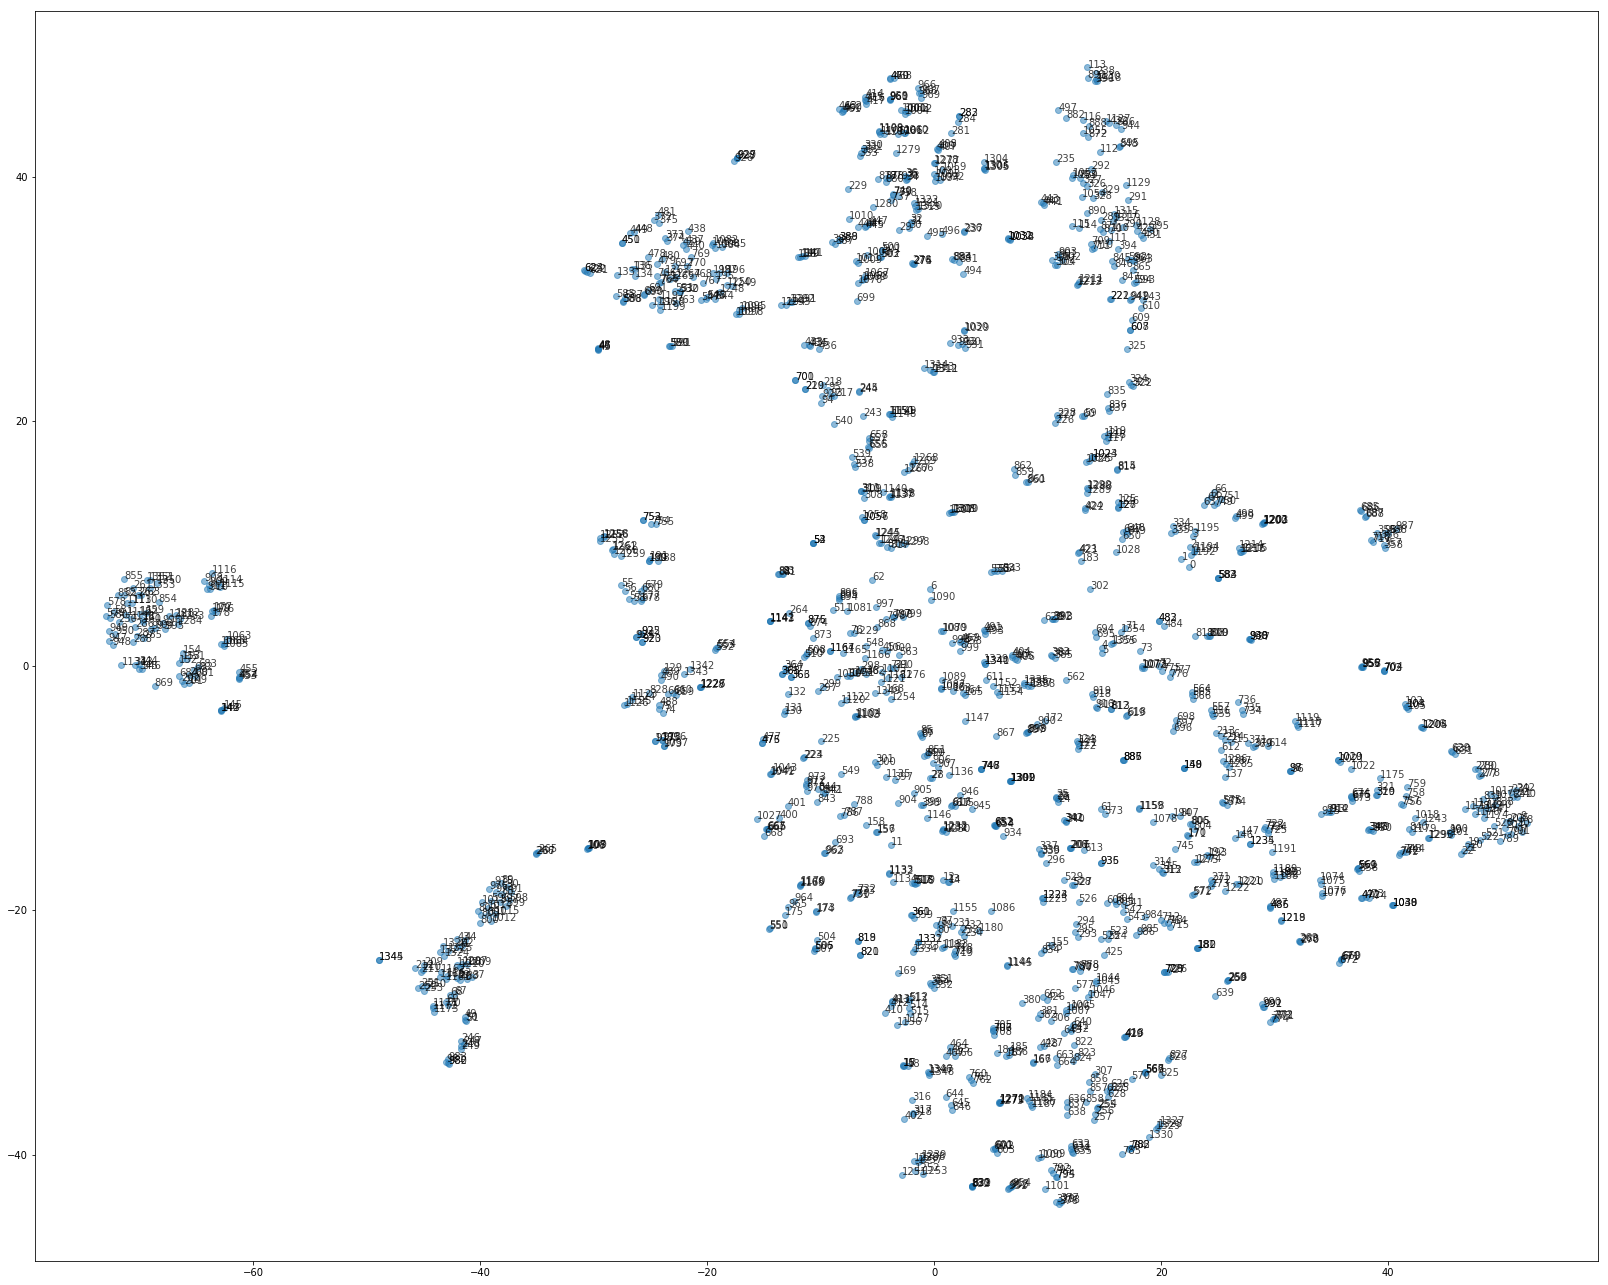

In [121]:
from sklearn.preprocessing import normalize
newdatas=newdata.values

normalized_newdatas = normalize(newdatas)

from sklearn.manifold import TSNE

plt.figure(figsize=(28,23))


# Create a TSNE instance: model
model = TSNE(learning_rate=50)

# Apply fit_transform to normalized_movements: tsne_features
tsne_features = model.fit_transform(normalized_newdatas)

# Select the 0th feature: xs
xs3 = tsne_features[:,0]

# Select the 1th feature: ys
ys3 = tsne_features[:,1]

# Scatter plot
plt.scatter(xs3, ys3, alpha=0.5)
# Annotate the points
for x0, y0, company in zip(xs3, ys3, range(0, 1357)):
    plt.annotate(company, (x0, y0), fontsize=10, alpha=0.75)
#plt.figure(figsize=(18,20))
plt.show()

In [122]:
newdatas

array([[ 3.06800000e+09, -2.22000000e+08, -1.96100000e+09, ...,
         4.00000000e+00, -2.41071429e+00,  0.00000000e+00],
       [ 4.97500000e+09, -9.30000000e+07, -2.72300000e+09, ...,
         4.00000000e+00, -2.24444444e+00,  0.00000000e+00],
       [ 4.66800000e+09, -1.60000000e+08, -1.50000000e+08, ...,
         4.00000000e+00,  1.33407963e+01,  1.00000000e+00],
       ...,
       [ 1.38100000e+09, -9.90000000e+07,  9.00000000e+06, ...,
         8.70000000e+01,  3.23663356e+01,  1.00000000e+00],
       [ 1.07100000e+09,  6.90000000e+07, -7.00000000e+06, ...,
         8.70000000e+01,  3.70948267e+01,  1.00000000e+00],
       [ 1.31300000e+09, -5.80000000e+07, -8.10000000e+07, ...,
         8.70000000e+01,  7.04705853e+01,  1.00000000e+00]])

## K-means for Merged_data before PCA

In [123]:
#import needed libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

x11=newdata.iloc[:,0:84].values

In [124]:
newdatav = newdata.iloc[:,0:84]

In [125]:
#x

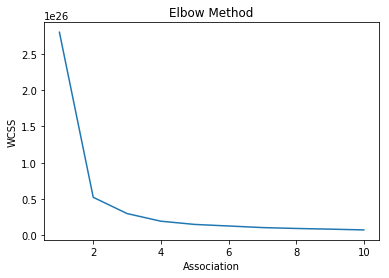

In [126]:
#Let's select the optimum number of clusters for k-means classification
from sklearn.cluster import KMeans
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                    max_iter = 400, n_init = 10, random_state = 0)
    kmeans.fit(x11)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Association')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

 It seems that the marginal critical point is when K = 3 or K = 4. I will try both k = 3 and k = 4.

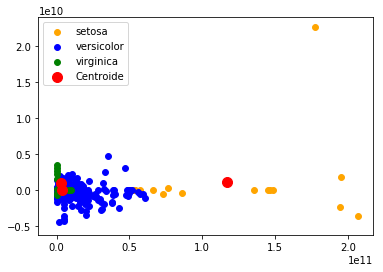

In [127]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 500, 
                n_init = 10, random_state = 0)
y_kmeans11 = kmeans.fit_predict(x11)

plt.scatter(x11[y_kmeans11 == 0, 0], x11[y_kmeans11 == 0, 1], s = 35, 
            c = 'orange', label = 'setosa')
plt.scatter(x11[y_kmeans11 == 1, 0], x11[y_kmeans11 == 1, 1], s = 35, 
            c = 'blue', label = 'versicolor')
plt.scatter(x11[y_kmeans11 == 2, 0], x11[y_kmeans11 == 2, 1], s = 35, 
            c = 'green', label = 'virginica')
#plt.scatter(x[y_kmeans == 3, 0], x[y_kmeans == 3, 1], s = 35, 
#            c = 'orange', label = 'black')

#Plotting the centroids of the clusters
plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:,1], s = 100, 
            c = 'red', label = 'Centroide')

plt.legend()

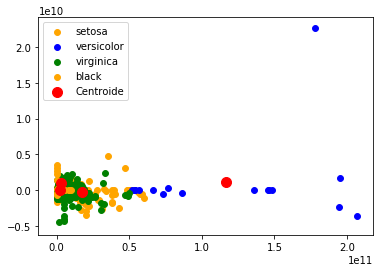

In [128]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 500, 
                n_init = 10, random_state = 0)
y_kmeans22 = kmeans.fit_predict(x11)

plt.scatter(x11[y_kmeans22 == 0, 0], x11[y_kmeans22 == 0, 1], s = 35, 
            c = 'orange', label = 'setosa')
plt.scatter(x11[y_kmeans22 == 1, 0], x11[y_kmeans22 == 1, 1], s = 35, 
            c = 'blue', label = 'versicolor')
plt.scatter(x11[y_kmeans22 == 2, 0], x11[y_kmeans22 == 2, 1], s = 35, 
            c = 'green', label = 'virginica')
plt.scatter(x11[y_kmeans22 == 3, 0], x11[y_kmeans22 == 3, 1], s = 35, 
            c = 'orange', label = 'black')

#Plotting the centroids of the clusters
plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:,1], s = 100, 
            c = 'red', label = 'Centroide')

plt.legend()

In [129]:
x11[y_kmeans11 == 0, 0]

array([1.48579e+11, 1.35662e+11, 1.45438e+11, 1.46286e+11, 5.70130e+10,
       5.37070e+10, 5.21800e+10, 5.37220e+10, 1.95240e+11, 1.94491e+11,
       2.06939e+11, 1.77638e+11, 7.66680e+10, 6.64360e+10, 8.61220e+10,
       7.33650e+10])

In [130]:
x11[y_kmeans22 == 0, 3]

array([ 18.,  22.,  16.,  11.,  11.,  11.,  16.,  20.,  22.,  24.,  27.,
        28.,  25.,   9.,   7.,   9.,   8.,   7.,   6.,   7.,   8.,   4.,
         9.,  10.,  10.,   9.,  19.,  14.,  12.,   3.,  46.,   5.,  26.,
        13.,  11.,  24.,   0.,   1.,   4.,  10.,  88.,  72., 101.,  92.,
        25.,  15.,  23.,   7.,  25.,  18.,  29.,  13.,  11.,   9.,  11.,
        13.,   8.,  10.,   9.,   9.,  10.,  10.,  11.,  11.,   9.,   6.,
         8.,   8.,  10.,   9.,   9.,   8.,  20.,   7.,  11.,  17.,   3.,
        30.,  78., 109.,  22.,  21.,  27.,  19.,  19.,   9.])

## K-means for Merged_data after PCA
### Integration with principal components 

We reduced the dimension from 84 to 20 with PCA

In [131]:
df11 = pd.DataFrame(data=reduced)
x21 = df11.iloc[:,0:19].values

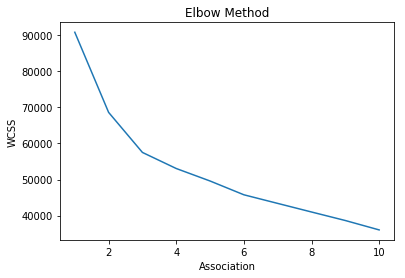

In [132]:
#Let's select the optimum number of clusters for k-means classification
from sklearn.cluster import KMeans
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                    max_iter = 400, n_init = 10, random_state = 0)
    kmeans.fit(x21)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Association')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

It seems that the marginal critical point is when K = 3. I will try both k = 3 and k = 4.

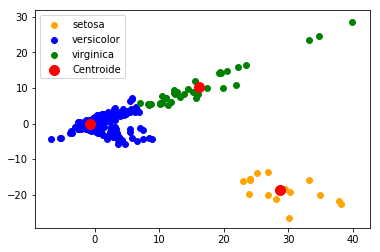

In [133]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 500, 
                n_init = 10, random_state = 0)
y_kmeans21 = kmeans.fit_predict(x21)

plt.scatter(x21[y_kmeans21 == 0, 0], x21[y_kmeans21 == 0, 1], s = 35, 
            c = 'orange', label = 'setosa')
plt.scatter(x21[y_kmeans21 == 1, 0], x21[y_kmeans21 == 1, 1], s = 35, 
            c = 'blue', label = 'versicolor')
plt.scatter(x21[y_kmeans21 == 2, 0], x21[y_kmeans21 == 2, 1], s = 35, 
            c = 'green', label = 'virginica')
#plt.scatter(x[y_kmeans == 3, 0], x[y_kmeans == 3, 1], s = 35, 
#            c = 'purple', label = 'black')

#Plotting the centroids of the clusters
plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:,1], s = 100, 
            c = 'red', label = 'Centroide')

plt.legend()

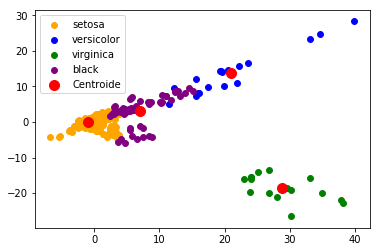

In [134]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 500, 
                n_init = 10, random_state = 0)
y_kmeans22 = kmeans.fit_predict(x21)

plt.scatter(x21[y_kmeans22 == 0, 0], x21[y_kmeans22 == 0, 1], s = 35, 
            c = 'orange', label = 'setosa')
plt.scatter(x21[y_kmeans22 == 1, 0], x21[y_kmeans22 == 1, 1], s = 35, 
            c = 'blue', label = 'versicolor')
plt.scatter(x21[y_kmeans22 == 2, 0], x21[y_kmeans22 == 2, 1], s = 35, 
            c = 'green', label = 'virginica')
plt.scatter(x21[y_kmeans22 == 3, 0], x21[y_kmeans22 == 3, 1], s = 35, 
            c = 'purple', label = 'black')

#Plotting the centroids of the clusters
plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:,1], s = 100, 
            c = 'red', label = 'Centroide')

plt.legend()

## DBSCAN before PCA

In [135]:
from sklearn.preprocessing import StandardScaler
import numpy as np
stscaler = StandardScaler().fit(newdatav)
data = stscaler.transform(newdatav)

In [136]:
from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = 30.7, min_samples = 5).fit(data)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

Text(0, 0.5, 'feature 1')

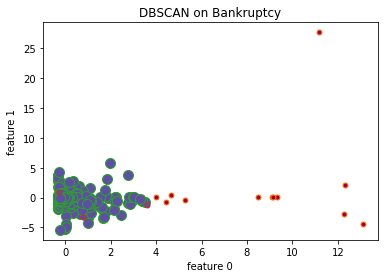

In [137]:
unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0,1, len(unique_labels)))
for (label, color) in zip(unique_labels, colors):
    class_member_mask = (labels == label)
    xy = data[class_member_mask & core_samples]
    plt.plot(xy[:,0],xy[:,1], 'o', markerfacecolor = color, markersize = 10)
    
    xy2 = data[class_member_mask & ~core_samples]
    plt.plot(xy2[:,0],xy2[:,1], 'o', markerfacecolor = color, markersize = 5)
plt.title("DBSCAN on Bankruptcy")
plt.xlabel("feature 0")
plt.ylabel("feature 1")

## DBSCAN after PCA

Text(0, 0.5, 'feature 1')

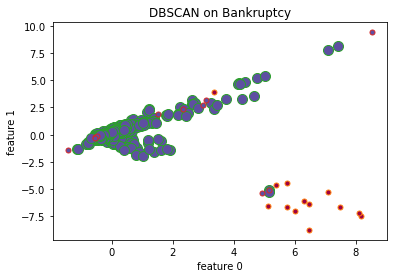

In [138]:
stscaler = StandardScaler().fit(df11)
data2 = stscaler.transform(df11)

dbsc = DBSCAN(eps = 13.6, min_samples = 5).fit(data2)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0,1, len(unique_labels)))
for (label, color) in zip(unique_labels, colors):
    class_member_mask = (labels == label)
    xy = data2[class_member_mask & core_samples]
    plt.plot(xy[:,0],xy[:,1], 'o', markerfacecolor = color, markersize = 10)
    
    xy2 = data2[class_member_mask & ~core_samples]
    plt.plot(xy2[:,0],xy2[:,1], 'o', markerfacecolor = color, markersize = 5)
plt.title("DBSCAN on Bankruptcy")
plt.xlabel("feature 0")
plt.ylabel("feature 1")

### Hierarchical Clustering before PCA

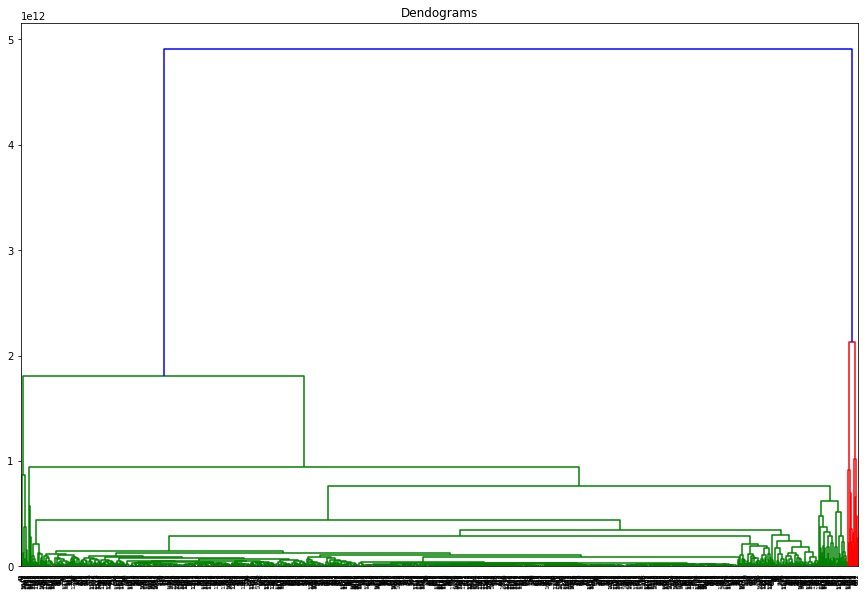

[118 117 122 ... 927 925 926]


In [139]:
import matplotlib.pyplot as plt  
%matplotlib inline
hdata = newdata.iloc[:,0:84].values

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
plt.figure(figsize=(15, 10))  
plt.title("Dendograms")
mergings = linkage(hdata, method='complete')#ward)

labels = fcluster(mergings, 70, criterion='distance')
dendrogram(mergings,leaf_rotation=90,leaf_font_size=6)
plt.show()

print(labels)

In [140]:
from sklearn.cluster import AgglomerativeClustering


cluster = AgglomerativeClustering(n_clusters=12, affinity='euclidean', 
                                  linkage='ward')  
cluster.fit_predict(hdata)  

array([0, 0, 0, ..., 7, 7, 7])

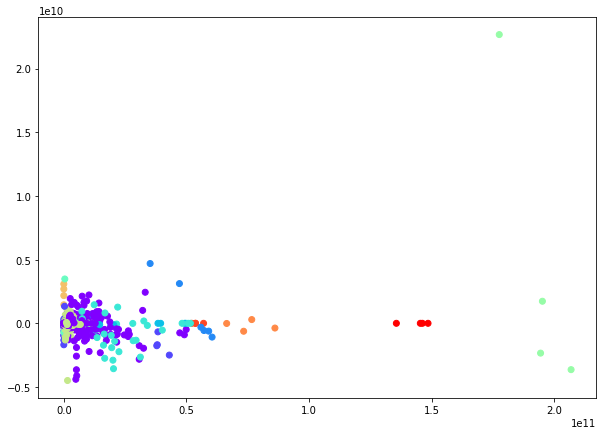

In [141]:
plt.figure(figsize=(10, 7))  
plt.scatter(hdata[:,0], hdata[:,1], c=cluster.labels_, cmap='rainbow')  

### Hierarchical Clustering after PCA

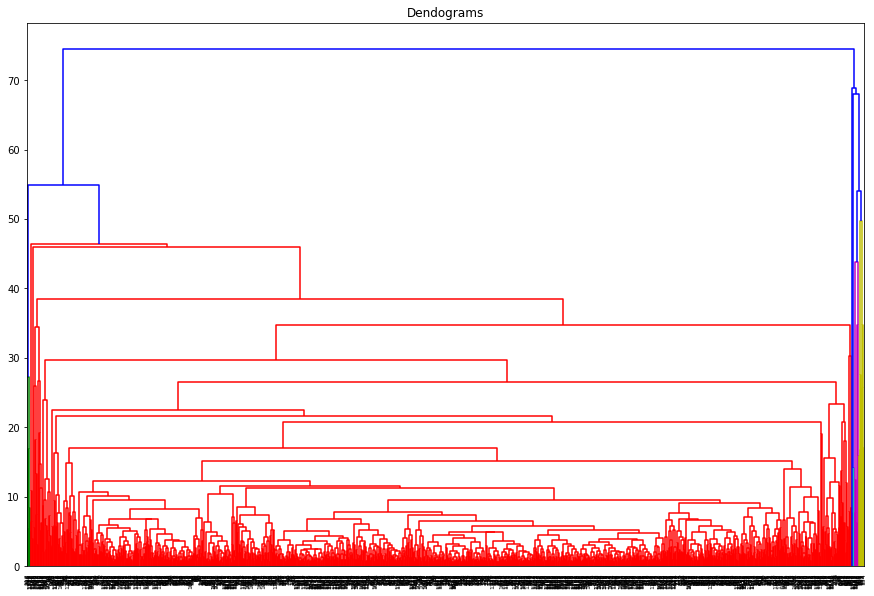

[1 1 1 ... 1 1 1]


In [142]:
import matplotlib.pyplot as plt  
%matplotlib inline
hdata = newdata.iloc[:,0:84].values

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
plt.figure(figsize=(15, 10))  
plt.title("Dendograms")

df11 = pd.DataFrame(data=reduced)
df22 = df11.iloc[:,0:19].values

mergings = linkage(df22, method='complete')#ward)

labels = fcluster(mergings, 70, criterion='distance')
dendrogram(mergings,leaf_rotation=90,leaf_font_size=6)
plt.show()

print(labels)

In [143]:
from sklearn.cluster import AgglomerativeClustering


cluster = AgglomerativeClustering(n_clusters=12, affinity='euclidean', 
                                  linkage='ward')  
cluster.fit_predict(df22)  

array([0, 0, 0, ..., 0, 0, 0])

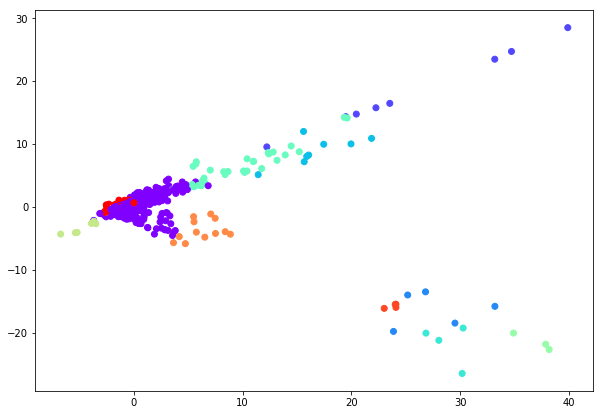

In [144]:
plt.figure(figsize=(10, 7))  
plt.scatter(df22[:,0], df22[:,1], c=cluster.labels_, cmap='rainbow')  

### Classification Models

In [145]:
#try some classification techniques

In [146]:
X=new_data2.iloc[:,0:84]
y=new_data2.trend

In [147]:
SEED=1
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)

In [148]:
def first_classifier(model):
    classifier = model()
    classifier.fit(X_train,y_train)
    print(classifier.score(X_test,y_test))
    #y_pred=classifier.predict(X_test)
    #print(metrics.accuracy_score(y_test, y_pred))
    return classifier

In [149]:
mod_logreg = first_classifier(LogisticRegression)
acc_log_reg = round( mod_logreg.score(X_test, y_test) * 100, 2)
mod_svc = first_classifier(SVC)
acc_svc = round( mod_svc.score(X_test, y_test) * 100, 2)

mod_linear_svc =first_classifier(LinearSVC)
acc_linear_svc = round( mod_linear_svc.score(X_test, y_test) * 100, 2)

mod_knn =first_classifier(KNN)
acc_knn = round( mod_knn.score(X_test, y_test) * 100, 2)

mod_decision_tree =first_classifier(DecisionTreeClassifier)
acc_decision_tree = round( mod_decision_tree.score(X_test, y_test) * 100, 2)

mod_random_forest=first_classifier(RandomForestClassifier)
acc_random_forest = round( mod_random_forest.score(X_test, y_test) * 100, 2)


0.9142156862745098
0.8921568627450981
0.9142156862745098
0.8995098039215687
1.0
1.0


In [150]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Support Vector Machines', 'Linear SVC', 
              'KNN', 'Decision Tree', 'Random Forest'],
    
    'Score': [acc_log_reg, acc_svc, acc_linear_svc, 
              acc_knn,  acc_decision_tree, acc_random_forest]
    })

models.sort_values(by='Score', ascending=False)

,Model,Score
4,Decision Tree,100.00
5,Random Forest,100.00
0,Logistic Regression,91.42
2,Linear SVC,91.42
3,KNN,89.95
1,Support Vector Machines,89.22


In [ ]:
#new_data3=new_data2[['symbol','date', 'After Tax ROE','Current Ratio','Earnings Before Interest and Tax','Earnings Before Tax','Gross Profit','Net Cash Flow','Net Income','Profit Margin','Quick Ratio','Total Assets','Total Equity','Total Liabilities','Total Liabilities & Equity','Total Revenue','For Year', 'Earnings Per Share','open', 'close', 'low', 'high', 'volume', 'Security', 'GICS Sector',
       #'GICS Sub Industry', 'PE']]